In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np
import pandas as pd
import h5py,os
import matplotlib as plt
from sklearn.metrics import roc_curve
from progressbar import ProgressBar
from sklearn.metrics import auc
import matplotlib.pyplot as plt
datadir = os.path.join(os.getcwd(), '..', 'data')

In [3]:
def conv_layer(inputs,filter_num,filter_size,dilation,stride = 1,padding = 'same',initilizer = 'glorot_normal'):
    conv_l = tf.keras.layers.Conv1D(filters = filter_num,
                                    kernel_size = filter_size,
                                    strides = stride,
                                    padding = padding,
                                    dilation_rate = dilation,
                                    kernel_initializer = initilizer
                                    )(inputs)
    conv_l = tf.keras.layers.BatchNormalization()(conv_l)
    conv_l = tf.keras.layers.Activation('relu')(conv_l)
    return conv_l

def residual_block(inputs,filter_num,filter_size,dilation,activation = 'relu'):
        #batch_norm+relu+conv+baatch+relu+conv+residual
        rb_bn1 = tf.keras.layers.BatchNormalization()(inputs)
        rb_ac1 = tf.keras.layers.Activation(activation)(rb_bn1)
        rb_conv1 = conv_layer(rb_ac1,filter_num,filter_size,dilation)
        rb_bn2 = tf.keras.layers.BatchNormalization()(rb_conv1)
        rb_ac2 = tf.keras.layers.Activation(activation)(rb_bn2)
        rb_conv2 = conv_layer(rb_ac2,filter_num,filter_size,dilation)
        residual_sum = tf.keras.layers.add([inputs,rb_conv2])
        return residual_sum
    
def filter_dataset(sequence,target):
    pbar = ProgressBar()
    del_list = []
    for i in pbar(range(0,len(target))):
        if any(y > 0.01 for y in target[i]):
            next
        else:
            del_list.append(i)
    print(len(del_list))
    filtered_seq = np.delete(sequence,del_list,0)
    filtered_target= np.delete(target,del_list,0)
   
    return filtered_seq,filtered_target


In [7]:
#5 output for basic, 21 for major, 
f = h5py.File(datadir+'/output_major.h5','r')
x_test = f['test_seq']
y_test = f['test_label']
#x_train = f['train_seq']
#y_train = f['train_label']
x_valid = f['valid_seq']
y_valid = f['valid_label']
save_model = datadir+'/model/filtered_model.h5'

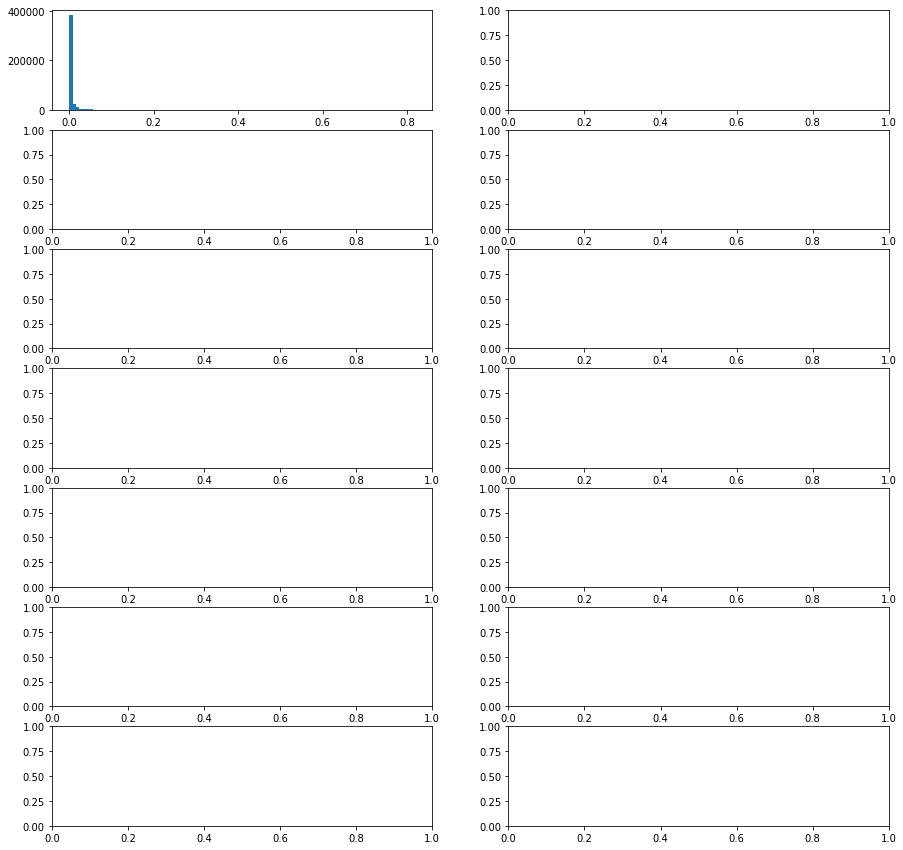

In [5]:
fig, axs = plt.subplots(7, 2,figsize=(15,15))
axs[0,0].hist(y_train[:,0],bins = 100);


In [8]:
#f_x_train,f_y_train= filter_dataset(x_train,y_train)
f_x_test,f_y_test= filter_dataset(x_test,y_test)
f_x_valid,f_y_valid= filter_dataset(x_valid,y_valid)

100% |########################################################################|


3493


2
3


100% |########################################################################|


6349
2
3


In [ ]:
output = h5py.File(datadir+'/major_filtered.h5','w')
output.create_dataset('test_seq', data=f_x_test, dtype='float32', compression="gzip")
output.create_dataset('test_label', data=f_y_test, dtype='float32', compression="gzip")
output.create_dataset('train_seq', data=f_x_train, dtype='float32', compression="gzip")
output.create_dataset('train_label', data=f_y_train, dtype='float32', compression="gzip")
output.create_dataset('valid_seq', data=f_x_valid, dtype='float32', compression="gzip")
output.create_dataset('valid_label', data=f_y_valid, dtype='float32', compression="gzip")

In [23]:
f_x_valid.shape

(20359, 4999, 4)

In [34]:
inputs = tf.keras.layers.Input(shape = (4999,4))


conv_1 = conv_layer(inputs,32,5,1)
conv_2 = conv_layer(conv_1,32,5,1)
conv_3 = conv_layer(conv_2,32,5,1)
mp_1 = tf.keras.layers.MaxPool1D()(conv_3)

conv_4 = conv_layer(mp_1,32,5,1)
conv_5 = conv_layer(conv_4,32,5,1)
conv_6 = conv_layer(conv_5,32,5,1)
mp_2 = tf.keras.layers.MaxPool1D()(conv_6)

lstm = tf.keras.layers.LSTM(128)(mp_2)
#flat = tf.keras.layers.Flatten()(mp_2)

dense_1 = tf.keras.layers.Dense(50,activation = 'relu',kernel_initializer='glorot_normal')(lstm)
dense_2 = tf.keras.layers.Dense(50,activation = 'relu',kernel_initializer='glorot_normal')(dense_1)
outputs = tf.keras.layers.Dense(21,activation = 'relu',kernel_initializer='glorot_normal')(dense_2)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.MeanSquaredError()
    
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(inputs = inputs,outputs = outputs,
                optimizer=optimizer,
                loss=loss,
                metrics=['mae'])

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 4999, 4)]         0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 4999, 32)          672       
_________________________________________________________________
batch_normalization_24 (Batc (None, 4999, 32)          128       
_________________________________________________________________
activation_24 (Activation)   (None, 4999, 32)          0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 4999, 32)          5152      
_________________________________________________________________
batch_normalization_25 (Batc (None, 4999, 32)          128       
_________________________________________________________________
activation_25 (Activation)   (None, 4999, 32)          0   

In [35]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                             min_delta=0, 
                                             patience=20, 
                                             verbose=1, 
                                             mode='min', 
                                             baseline=None, restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=0.5,
                                                 patience=5, 
                                                 min_lr=1e-7,
                                                 mode='min',
                                                 verbose=1)

checkpoint = tf.keras.callbacks.ModelCheckpoint(save_model, 
                                                monitor='val_loss', 
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='min')

In [36]:
training = model.fit(f_x_train,f_y_train,
                    epochs=200,
                    batch_size = 64,
                    callbacks = [earlystop,reduce_lr,checkpoint], 
                    validation_data = (f_x_valid,f_y_valid)
                    )

Train on 381520 samples, validate on 20359 samples
Epoch 1/200
381504/381520 [============================>.] - ETA: 0s - loss: 7.6149e-04 - mae: 0.0149
Epoch 00001: val_loss improved from inf to 0.00064, saving model to /mnt/1a18a49e-9a31-4dbf-accd-3fb8abbfab2d/brain_atac/notebooks/../data/model/filtered_model.h5
381520/381520 [==============================] - 553s 1ms/sample - loss: 7.6147e-04 - mae: 0.0149 - val_loss: 6.4435e-04 - val_mae: 0.0147
Epoch 2/200
381504/381520 [============================>.] - ETA: 0s - loss: 7.2259e-04 - mae: 0.0149
Epoch 00002: val_loss improved from 0.00064 to 0.00063, saving model to /mnt/1a18a49e-9a31-4dbf-accd-3fb8abbfab2d/brain_atac/notebooks/../data/model/filtered_model.h5
381520/381520 [==============================] - 555s 1ms/sample - loss: 7.2260e-04 - mae: 0.0149 - val_loss: 6.3457e-04 - val_mae: 0.0143
Epoch 3/200
381504/381520 [============================>.] - ETA: 0s - loss: 7.1986e-04 - mae: 0.0149
Epoch 00003: val_loss did not impro

KeyboardInterrupt: 

In [ ]:
model = tf.keras.models.load_model(datadir+'/model/filtered_model.h5')
y_pred = model.predict(f_x_test[()])

In [15]:
y_pred[1]

array([[0.59029084, 0.9951866 , 0.87316   , 0.74109536, 0.93533593],
       [0.5378398 , 0.97819597, 0.79155314, 0.6728945 , 0.8759048 ],
       [0.170773  , 0.85963535, 0.3081839 , 0.19543484, 0.4607337 ],
       ...,
       [0.1599878 , 0.75674427, 0.25005984, 0.25322568, 0.55076116],
       [0.6152369 , 0.9941505 , 0.8963051 , 0.74880475, 0.9346398 ],
       [0.55563825, 0.9669058 , 0.8370737 , 0.7037844 , 0.8618056 ]],
      dtype=float32)

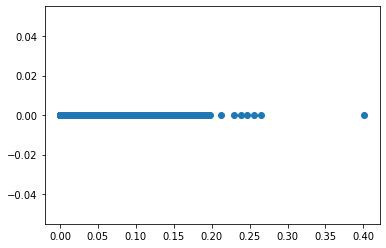

In [33]:
plt.scatter(f_y_test[:,1],y_pred[:,1])

In [23]:
model.evaluate(y_pred,[y_valid,y_valid_bool])

ValueError: Error when checking input: expected input_1 to have 3 dimensions, but got array with shape (38134, 5)